<a href="https://colab.research.google.com/github/jahnavi-maddhuri/JahnaviMaddhuri-DukeXAI/blob/main/mechanistic_interpreter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jahnavi-maddhuri/JahnaviMaddhuri-DukeXAI/blob/main/mechanistic_interpreter.ipynb)

# Interpreting an MLP that Attempts for String Reversal
#### Jahnavi Maddhuri

Multilayer Perceptrons have grown to be powerful feed forward neural networks made of fully connected layers that are stacked on top of each other. These layers begin with an input layer, end with an output layer and have at least one hidden layer in between. Often times, with these powerful models, interpretability goes out the window and the model user often has no idea what is happening behind the scenes of these predictions.

In this notebook I try to demystify the black box to improve explainability and interpretability of these types of models. I use a very simple use case and model below to start by explaining a simpler, smaller example that can then be extrapolated to understand more complex models as well.

In the example below, my MLP has one input, only one hidden layer and one output layer, keeping it simple. Next, my MLPs objective is to use one-hot-encoded strings and produce them in reverse order. I use synthetic data to fit this model with the simple use case of reversing strings of length three with from vocab size of three.

To better understand what Multilayer Perceptrons were, how to understand the hidden layers and activation functions and also develop the scripts and fine tune them, I often used ChatGPT 5.1. Feel free to read the conversation here: https://chatgpt.com/c/69167c70-ee64-8327-9be2-f76bafb68287

In [32]:
# Necessary Library Improts for NN
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt


### Data Generation
First, I generate synthetic data below so the model can train and test on this dataset. For simplicity, my strings are only of length three and only have an alphabet with three characters, a, b and c. The generated X are 2500 records with each letter one-hot-encoded to form a matrix with dimensions (2500 x 3 x 3). For y, the output sequence are array representations of the index encodings. This is a matrix with dimensions (2500 x 3).

For training and testing, I split this dataset into 2000 training samples and 500 testing samples.

In [21]:
def generate_string_dataset(n_train=2000, n_test=500, seq_length=3, alphabet="abc"):
    """
    Generates synthetic data for string reversal.

    X: one-hot encoded original strings
       shape: (n_samples, seq_length, vocab_size), dtype=float32
    y: reversed strings as integer indices
       shape: (n_samples, seq_length), dtype=long
    """
    n_samples = n_train + n_test
    vocab = list(alphabet)
    vocab_size = len(vocab)
    char_to_idx = {ch: i for i, ch in enumerate(vocab)}

    X = torch.zeros(n_samples, seq_length, vocab_size, dtype=torch.float32)
    y = torch.zeros(n_samples, seq_length, dtype=torch.long)

    for n in range(n_samples):
        # random string of exactly seq_length
        s = ''.join(random.choice(vocab) for _ in range(seq_length))

        # one-hot encode original string into X[n]
        for t, ch in enumerate(s):
            X[n, t, char_to_idx[ch]] = 1.0

        # reversed string → indices
        s_rev = s[::-1]
        for t, ch in enumerate(s_rev):
            y[n, t] = char_to_idx[ch]

    # Optional: shuffle before splitting
    perm = torch.randperm(n_samples)
    X = X[perm]
    y = y[perm]

    # Train/test split
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test  = X[n_train:n_train + n_test]
    y_test  = y[n_train:n_train + n_test]

    return X_train, y_train, X_test, y_test, vocab, char_to_idx

In [22]:
X_train, y_train, X_test, y_test, vocab, char_to_idx = generate_string_dataset()
seq_length = X_train.size(1)
vocab_size = X_train.size(2)
print(f'Dimensions of X (train):{X_train.shape}')  # (2000, 3, 3)
print(f'Dimensions of y (train):{y_train.shape}') # (2000, 3)

Dimensions of X (train):torch.Size([2000, 3, 3])
Dimensions of y (train):torch.Size([2000, 3])


### Build my String Reversal MLP
This simple model has the architecture (1) Input Layer, (2) Hidden Layer, (3) Output Layer. My Input Layer takes in one-hot-encodings of the strings. I set my hidden layer to be of size 10. This means that there are 10 internal neurons, or features that the model uses to learn the reversal behavior. Each hidden neuron is meant to detect a slightly different pattern, and thus is tuned to a different weight through the model's training process.

Below, I create the MLP, train and test the model, producing evaluation metrics at the end of the process.

In [23]:
class StringReverseMLP(nn.Module):
    def __init__(self, seq_length, vocab_size, hidden_dim=10):
        super().__init__()
        self.seq_length = seq_length
        self.vocab_size = vocab_size

        # Input is flattened one-hot: seq_length * vocab_size
        input_dim = seq_length * vocab_size

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, seq_length * vocab_size)

    def forward(self, x):
        """
        x: (batch_size, seq_length, vocab_size) one-hot
        returns:
          logits: (batch_size, seq_length, vocab_size)
          h:      (batch_size, hidden_dim)
        """
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)  # (batch_size, seq_length * vocab_size)

        h = F.relu(self.fc1(x_flat))
        logits_flat = self.fc2(h)  # (batch_size, seq_length * vocab_size)
        logits = logits_flat.view(batch_size, self.seq_length, self.vocab_size)

        return logits, h

In [24]:
# Instantiate model (one hidden layer, 10 activations)
model = StringReverseMLP(seq_length=seq_length,
                         vocab_size=vocab_size,
                         hidden_dim=10)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

losses = []
for epoch in range(100):
    model.train()

    # Forward
    logits, h = model(X_train)           # (N, L, V)
    N, L, V = logits.shape

    # Flatten for CrossEntropyLoss
    logits_flat = logits.view(N * L, V)  # (N*L, V)
    targets_flat = y_train.view(N * L)   # (N*L,)

    loss = criterion(logits_flat, targets_flat)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

print("Final training loss:", losses[-1])


StringReverseMLP(
  (fc1): Linear(in_features=9, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=9, bias=True)
)
Final training loss: 0.015789007768034935


In [25]:
model.eval()
with torch.no_grad():
    logits_val, h_val = model(X_test)
    preds_idx = logits_val.argmax(dim=-1)  # (N, L)

    # Per-position accuracy
    per_pos_acc = (preds_idx == y_test).float().mean().item()

    # Exact string accuracy (all positions correct)
    exact_match = (preds_idx == y_test).all(dim=1).float().mean().item()

print(f"Per-position accuracy: {per_pos_acc:.2f}")
print(f"Exact string accuracy: {exact_match:.2f}")


Per-position accuracy: 1.00
Exact string accuracy: 1.00


Wow! The MLP is an excellent predictor for the reversal of size 3 strings of size 3 vocab.

# Explanations
While this accuracy is extremely high and the model appears to work well, we still don't really understand what's happening underneath the hood. Let's dive deep into a specific example from our test set to understand what our model predicted and how it got to that prediction.

In [26]:
def decode_indices(idx_tensor, vocab):
    return ''.join(vocab[int(i)] for i in idx_tensor)

sample_idx = 0
x_sample = X_test[sample_idx:sample_idx+1]  # (1, L, V)
y_sample = y_test[sample_idx]               # (L,)

with torch.no_grad():
    logits_sample, hidden_sample = model(x_sample)
    probs_sample = torch.softmax(logits_sample, dim=-1)  # (1, L, V)
    pred_idx_sample = logits_sample.argmax(dim=-1).squeeze(0)  # (L,)

orig_idx = X_test[sample_idx].argmax(dim=-1)  # original string indices (L,)
orig_str = decode_indices(orig_idx, vocab)
true_rev_str = decode_indices(y_sample, vocab)
pred_rev_str = decode_indices(pred_idx_sample, vocab)

print("Original string:      ", orig_str)
print("True reversed string: ", true_rev_str)
print("Predicted reversed:   ", pred_rev_str)
print("\nHidden layer activations:")
print(hidden_sample)       # (1, 10)
print("\nOutput logits:")
print(logits_sample)
print("\nOutput probabilities (softmax):")
print(probs_sample)


Original string:       caa
True reversed string:  aac
Predicted reversed:    aac

Hidden layer activations:
tensor([[0.3527, 2.0791, 0.0000, 0.4394, 1.2441, 2.0205, 0.0000, 1.0842, 2.1860,
         0.0000]])

Output logits:
tensor([[[ 3.0430, -1.6365, -1.1535],
         [ 1.6996, -2.5423, -3.1467],
         [-2.3591, -1.9624,  2.3057]]])

Output probabilities (softmax):
tensor([[[0.9762, 0.0091, 0.0147],
         [0.9782, 0.0141, 0.0077],
         [0.0092, 0.0137, 0.9771]]])


## Comparing Two Inputs
To understand how these activations change in accordance to different inputs, let's consider two very similar inputs and inspect how the model responds.

**Two inputs** `aba` vs `aca`
I choose these two inputs because they are very similar, containing the same first and last letters - both a. The only thing that changes between these two outputs is the middle layer.

**Hypothesis**
I hypothesize that the hidden activations will be largely similar for both inputs, with a few largely divergent neurons. I hypothesize that some neurons will capture behavior from the first letter, some from the second and some from the third. I also believe there may be neurons that capture patterns like symmetry and the idea that the second letter never changes. Let's see what happens below!

In [30]:
def encode_string(s, vocab, char_to_idx):
    seq_length = len(s)
    vocab_size = len(vocab)
    x = torch.zeros(1, seq_length, vocab_size)
    for i, ch in enumerate(s):
        x[0, i, char_to_idx[ch]] = 1.0
    return x

# Encode "aba" and "aca"
x_aba = encode_string("aba", vocab, char_to_idx)
x_aca = encode_string("aca", vocab, char_to_idx)

with torch.no_grad():
    logits_aba, h_aba = model(x_aba)
    logits_aca, h_aca = model(x_aca)

print("Hidden activations for ABA:", h_aba)
print("Hidden activations for ACA:", h_aca)
print("Difference:", abs(h_aba - h_aca))

Hidden activations for ABA: tensor([[1.7772, 0.9901, 0.6879, 1.7629, 3.2027, 0.0000, 0.0000, 1.2680, 2.6102,
         0.6145]])
Hidden activations for ACA: tensor([[1.4226, 1.0950, 0.0000, 3.2157, 1.6844, 0.0792, 0.0000, 2.3255, 1.5218,
         0.6398]])
Difference: tensor([[0.3546, 0.1049, 0.6879, 1.4527, 1.5183, 0.0792, 0.0000, 1.0575, 1.0884,
         0.0253]])


This output matches the hypothesis. We see that some activations have extremely small difference, while some are much more divergent. Ordering by the absolute difference, I sort my neurons into the three categories below.

**Large Differences** <br>
Neuron 7 (1.06), Neuron 8 (1.09), Neuron 3 (1.45), Neuron 4 (1.52)

- In the larger differences category, these neurons likely represent the encoding in the second letter or the encodings for "b" vs "c."

**Moderate Differences** <br>
Neuron 0 (0.35), Neuron 2 (0.69)
- In the moderate differences category, these neurons may represent global patterns, perhaps like encoding that the first and last letter are the same.

**Small Differences** <br>
Neuron 6 (0.00), Neuron 9 (0.03), Neuron 5 (0.08), Neuron 1 (0.10)

- It appears as though these neurons may represent the first or last letters, or the encoding `a` as these are all attributes that are common and similar between the two inputs. All these neurons fall in the group of having only small differences between the activations from one hidden layer to the next.

**No Activation** <br>
Neuron 6 actually consistently had no activation, representing a silent neuron that is encoding a feature that is consistent to both inputs.

## Plot
Now, let's consider three inputs, `aba`, `aca` and `aaa`. Below, I build a heatmap of each neuron's distance from the average activation.

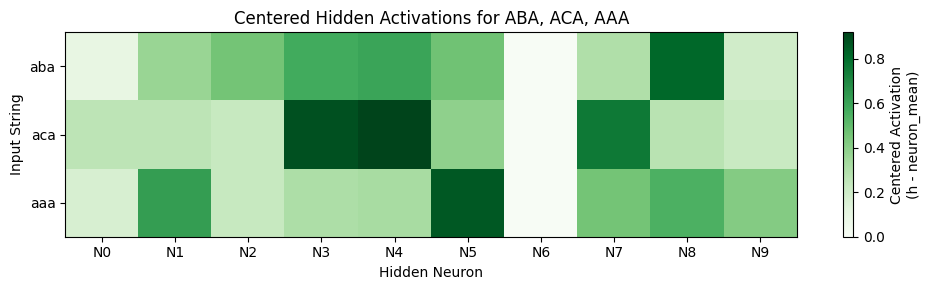

In [38]:
inputs = ["aba", "aca", "aaa"]
hidden_list = []

model.eval()
with torch.no_grad():
    for s in inputs:
        x = encode_string(s, vocab, char_to_idx)
        logits, h = model(x)     # h shape: (1, hidden_dim)
        hidden_list.append(h.squeeze(0))  # remove batch dimension

# Stack into shape (3, hidden_dim)
H = torch.stack(hidden_list, dim=0)  # e.g., (3, 10)

# --- Center activations per neuron: subtract neuron-wise mean ---
neuron_means = H.mean(dim=0, keepdim=True)   # (1, hidden_dim)
H_centered = abs(H - neuron_means)                # (3, hidden_dim)

# Convert to numpy
H_centered_np = H_centered.numpy()

# --- Plot: Heatmap comparing ABA, ACA, AAA ---
plt.figure(figsize=(10, 3))
im = plt.imshow(H_centered_np, cmap='Greens',# cmap="viridis",
                aspect='auto')

plt.colorbar(im, label="Centered Activation\n(h - neuron_mean)")

# X-axis = neurons
plt.xticks(
    ticks=np.arange(H_centered_np.shape[1]),
    labels=[f"N{i}" for i in range(H_centered_np.shape[1])]
)

# Y-axis = input strings
plt.yticks(ticks=np.arange(len(inputs)), labels=inputs)

plt.xlabel("Hidden Neuron")
plt.ylabel("Input String")
plt.title("Centered Hidden Activations for ABA, ACA, AAA")
plt.tight_layout()
plt.show()


In the heatmap above, the darker greens represent large differences in activations while the lighter and white greens represent smaller differences. A similar trend to what we saw earlier holds true here as well.

The strongest pattern, is the consistency in the small differences. Neurons 0, 1, 5, 6 and 9 continued to show small to moderate differences, reinforcing the idea that these represent the first or last letters, the encoding "a" or the symmetry as these are all consistent amongst the inputs.

Some of the largest differences still come from Neurons 3, 4, 5, 7 and 8. These neurons capture some of the nuance in the second letter. Neuron 5 is largely different in `aaa` than the other two inputs - perhaps this neuron captures cases were all the letters are the same.

### Reflection
***What did I learn about how my model works?*** <br>
I learned a lot more about how each neuron works and what it's properties might look like. I understand now that there are three main functions of a neuron (1) local feature detectors that respond to a specific position or character of the input, (2) global pattern indicators like symmetry and (3) irrelevant or silent neurons that encodes irrelevant features to the input. <br> <br>

***What was confusing, surprising, or challenging to interpret?*** <br>
Because I only used three key inputs, it was difficult to interpret the specifics of which neuron corresponded to which pattern recognition and how this was getting encoded. I understand holistically how the neurons work and what types of signals they could send, but the specific interpretability of exact functions of each neuron is difficult to isolate. <br> <br>

***What’s one thing I wish I could understand better or explore further?***
Neuron 6 was fascinating to me because it kept capturing an irrelevant feature for all of my inputs. I'm really intrigued to know what is consistently encoding since there are many aspects to all three inputs that are consistent.